The goal is to create and tune a model that can distinguish between real and fake news. The dataset given is a mix of real and fake with the corresponding labels

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt
/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
import pandas as pd
import numpy as np
import time
import gc

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

### 1. Import the data

In [3]:
true = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')
fake = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')

In [4]:
display(true.head())
display(fake.head())

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Combine both datasets. Before that add a `tag` to mark fo real or fake
- True: 1
- Fake: 0

In [5]:
true['category'] = 1
fake['category'] = 0

df = pd.concat([true, fake])
print('True data shape', true.shape)
print('fake data shape', fake.shape)
print('Combined data shape', df.shape)

True data shape (21417, 5)
fake data shape (23481, 5)
Combined data shape (44898, 5)


### 2. 'Subjects' or topics in each class

In [6]:
print('True news....\n',true.subject.value_counts())
print('\nFake news....\n',fake.subject.value_counts())

True news....
 politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

Fake news....
 News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64


### 3. Check for imbalance in dataset
- Dataset is almost balanced

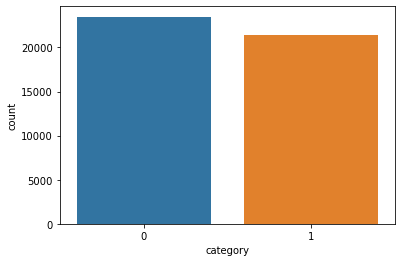

In [7]:
sns.countplot(df.category)

Check for any missing values

In [8]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

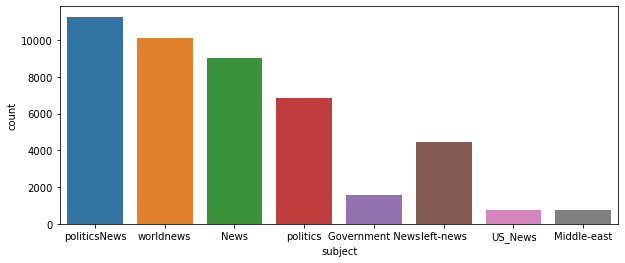

In [9]:
plt.figure(figsize=(10,4))
sns.countplot(df.subject)

Text(0.5, 1.0, 'Topics by category')

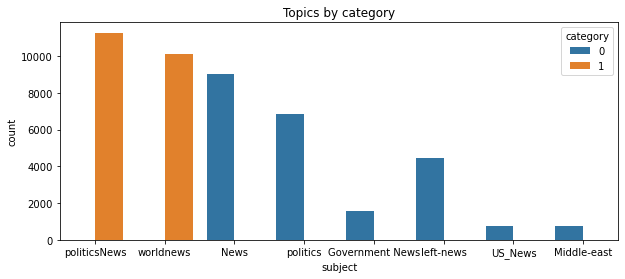

In [10]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x ='subject', hue='category')
plt.title('Topics by category')

There is clear difference in the range of topics between fake and true, simply based on the `subject`. To prevent any data leaks in further text processing, the `subject` column will be ignored.

- Combine `title` and `text`

In [11]:
df['text'] = df['title'] + " " + df['text']

df = df.drop(['title', 'date', 'subject'], axis=1)
df.head()

,text,category
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


Examine some text from either category

In [12]:
grouped_df = df.groupby('category')['text']
for cat, text in grouped_df:
    print('category', cat, '\ntext: \n', text.tolist()[:2])
    print('\n')

category 0 
text: 
 [' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year 

We can either extract meta features from the text and use them as new features for our ML model, like count of punctuations, special characters, word length, average word count etc.

Here I will make use of pre-trained embeddings and for that I will need to clean the text first, so that tokens from the embeddings can be matched as much as possible

Since there are `html components` in the text it is better to use an html parser such as `BeautifulSoup` to extract text from html

In [13]:
from bs4 import BeautifulSoup

def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [14]:
sample = df.sample(frac=0.01)
sample.shape

(449, 2)

In [15]:
%%time

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

porter = PorterStemmer()
lemma = WordNetLemmatizer()

stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    words = word_tokenize(text)
    words = [lemma.lemmatize(w) for w in words if w not in stopwords]
    words = [w for w in words if w.isalpha()]
    text = " ".join(w for w in words)
    return text


df['text'] = df['text'].apply(strip_html)
df['text'] = df['text'].apply(clean_text)

CPU times: user 5min 26s, sys: 664 ms, total: 5min 27s
Wall time: 5min 29s


In [16]:
df['text'].head()

0    budget fight loom republican flip fiscal scrip...
1    military accept transgender recruit monday pen...
2    senior republican senator mueller job washingt...
3    fbi russia probe helped australian diplomat ny...
4    trump want postal service charge amazon shipme...
Name: text, dtype: object

### Creating a WordCloud for a simple nice view into both categories

### WordCloud for *True* news(label=1)

Text(0.5, 1.0, 'Word Cloud for True Stories: Label: 1')

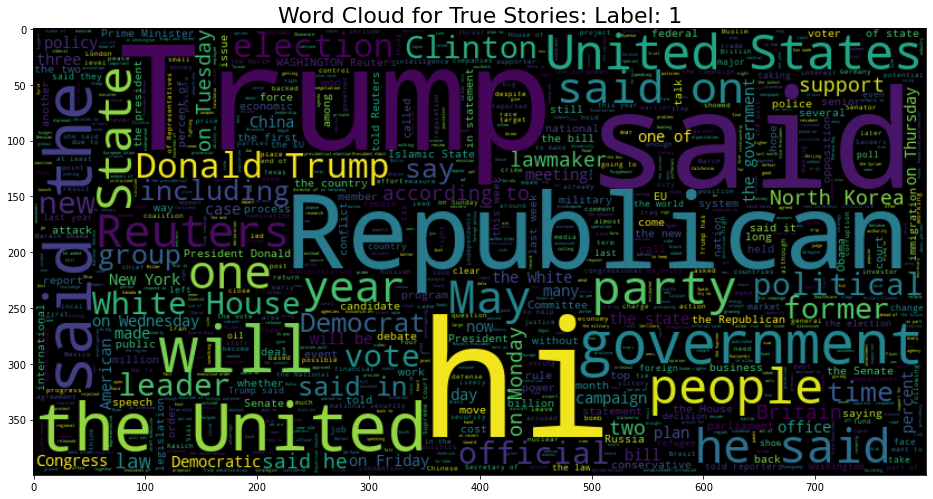

In [17]:
from wordcloud import WordCloud

# using only a fraction of the true dataset to save computation time
sample_true = true.sample(frac=0.01)

# create a wordcloud for the same
# word cloud expects an iterator of texts as input to generate
wc_true = WordCloud(width=800, height=400, max_words=1000).generate(' '.join(sample_true.loc[sample_true['category'] == 1, 'text']))

# interpolation='bilinear' is to smoothen the image
plt.figure(figsize=(16,10))
plt.imshow(wc_true, interpolation='bilinear')
plt.title('Word Cloud for True Stories: Label: 1', fontsize=22)

Text(0.5, 1.0, 'Word Cloud for Fake Stories: Label: 0')

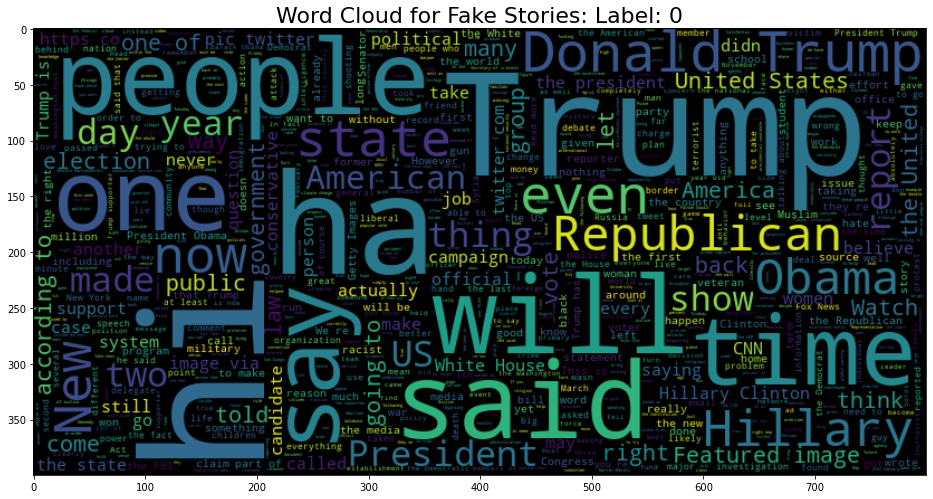

In [18]:
# using only a fraction of the true dataset to save computation time
sample_fake = fake.sample(frac=0.01)

# create a wordcloud for the same
# word cloud expects an iterator of texts as input to generate
wc_true = WordCloud(width=800, height=400, max_words=1000).generate(' '.join(sample_fake.loc[sample_fake['category'] == 0, 'text']))

# interpolation='bilinear' is to smoothen the image
plt.figure(figsize=(16,10))
plt.imshow(wc_true, interpolation='bilinear')
plt.title('Word Cloud for Fake Stories: Label: 0', fontsize=22)

The WordCloud does not give a clear picture for true and fake stories and the prominent tokens or text seem to be mostly the same

### Split data in train and valid for further analysis

Looks like there are duplicates in the text. Lets remove them to reduce the dimensions

In [19]:
original_shape = len(df)
print(df.shape)
print('Removing duplicates in text......')
df = df.drop_duplicates(subset='text', keep='first')
print(df.shape)
new_shape = len(df)
print('Removed {} duplicate rows from the dataset'.format(original_shape - new_shape))

(44898, 2)
Removing duplicates in text......
(38942, 2)
Removed 5956 duplicate rows from the dataset


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df.text, df.category, test_size =0.2, random_state=2020)

* Use `Keras Tokenizer` to tokenize the input cleaned text
* Once tokenized, the individual tokens are encoded as integer
* The original `word -> integer` mapping is stored in `word_index`, which can be further checked using `word_index.items()`, which is a dict
* Define a max_len for input sequence
    * `Truncate` if exceed `max_len`
    * `Pad` with '0' if less then `max_len`, well there is a choice to pad in the front or the back, based on the `padding` parameter but this is not important . Refer [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)
    
* The Keras tokenizer does some basic text processing, using filters. More details [here](https://keras.io/api/preprocessing/text/)

* Since the news text is quite long, `max_len = 300` should be a reasonable choice 

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
print('tensor flow version in use: ', tf.__version__)

Using TensorFlow backend.


tensor flow version in use:  2.2.0


In [22]:
# max_features to extract from the text
# the maximum number of words to keep, based on word frequency

max_features = 20000
max_len = 300    # max length of input sequence of text news
embed_size = 100 # size of the embedding vector for each token from the max_features

In [23]:
%%time
tokenizer = Tokenizer(num_words= max_features)
# Once fit, the tokenizer provides 4 attributes that you can use to query what has been learned about your documents as listed below
tokenizer.fit_on_texts(X_train)

CPU times: user 6.05 s, sys: 16 ms, total: 6.07 s
Wall time: 6.09 s


* **tokenizer.word_index** : A dictionary of words -> uniquely assigned integers. Lower the index value, higher the frequency. Index `0` is reserved for `padding`
* **tokenizer.document_count** : An integer count of the total number of documents that were used to fit the Tokenizer
* **tokenizer.word_counts** : A dictionary of words and their counts
* **tokenizer.word_docs** : A dictionary of words and how many documents each appeared in
* **tokenizer.texts_to_matrix()** : Creates one vector per document provided per input. The length of the vectors is the total size of the vocabulary.
* **tokenizer.texts_to_sequences** : Transforms each text in to a `sequence of integers`. So it basically takes each word in the text and replaces it with its corresponding integer value from the `word_index` dictionary.

In [24]:
# Most common words used in the vocabulary are as below. Lower the index, the more frequent it is
# tokenizer.word_index

n=10
for k, v in tokenizer.word_index.items():
    print(k, ":", v)
    n-=1
    if n == 0:
        break

trump : 1
said : 2
state : 3
would : 4
president : 5
republican : 6
people : 7
one : 8
year : 9
new : 10


In [25]:
%%time
tokenized_train = tokenizer.texts_to_sequences(X_train)
tokenized_valid = tokenizer.texts_to_sequences(X_valid)

# now pad
tokenized_train_padded_X = pad_sequences(tokenized_train, maxlen = max_len)
tokenized_valid_padded_X = pad_sequences(tokenized_valid, maxlen = max_len)

CPU times: user 7.64 s, sys: 17 ms, total: 7.65 s
Wall time: 7.65 s


We will make use of some __pretrained embeddings__. Here I will specifically use the glove embedding trained on twitter which has 27 billion tokens with embedding size of 100.
There are other pretrained embeddings such as fastext, paragram etc

In [26]:
EMBEDDING_FILE = '../input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt'

In [27]:
# examine file contents

with open(EMBEDDING_FILE, 'r') as fp:
    for i in range(3):
        print(fp.readline())

<user> 0.63006 0.65177 0.25545 0.018593 0.043094 0.047194 0.23218 0.11613 0.17371 0.40487 0.022524 -0.076731 -2.2911 0.094127 0.43293 0.041801 0.063175 -0.64486 -0.43657 0.024114 -0.082989 0.21686 -0.13462 -0.22336 0.39436 -2.1724 -0.39544 0.16536 0.39438 -0.35182 -0.14996 0.10502 -0.45937 0.27729 0.8924 -0.042313 -0.009345 0.55017 0.095521 0.070504 -1.1781 0.013723 0.17742 0.74142 0.17716 0.038468 -0.31684 0.08941 0.20557 -0.34328 -0.64303 -0.878 -0.16293 -0.055925 0.33898 0.60664 -0.2774 0.33626 0.21603 -0.11051 0.0058673 -0.64757 -0.068222 -0.77414 0.13911 -0.15851 -0.61885 -0.10192 -0.47 0.19787 0.42175 -0.18458 0.080581 -0.22545 -0.065129 -0.15328 0.087726 -0.18817 -0.08371 0.21779 0.97899 0.1092 0.022705 -0.078234 0.15595 0.083105 -0.6824 0.57469 -0.19942 0.50566 -0.18277 0.37721 -0.12514 -0.42821 -0.81075 -0.39326 -0.17386 0.55096 0.64706 -0.6093

. 0.18205 -0.048483 0.23966 0.32099 -0.27002 0.70431 -0.21257 0.235 0.090142 0.82141 0.37843 -0.56382 -2.4447 0.16827 0.24685 0.28649

In [28]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

In [29]:
word_index = tokenizer.word_index
print('Number of unique tokens in the train vocab is : {}'.format(len(word_index)))
print('Max features: ', max_features)

nb_words = min(max_features, len(word_index))

# adding 1, to store missing tokens from the pretrained embedding
embedding_index = np.zeros((nb_words +1, embed_size))

Number of unique tokens in the train vocab is : 83454
Max features:  20000


In [30]:
%%time
with open(EMBEDDING_FILE, 'r') as fp:
    embedding_index = dict(get_coefs(*o.split(" ")) for o in fp)

CPU times: user 55.7 s, sys: 1.43 s, total: 57.2 s
Wall time: 57.2 s


In [31]:
%%time

all_embeds = np.stack(list(embedding_index.values()))
embeds_mean, embeds_std = all_embeds.mean(), all_embeds.std()

# create a random normal distribution from the above
embedding_matrix = np.random.normal(embeds_mean, embeds_std, (nb_words +1, embed_size))
print('embeds_mean', embeds_mean)
print('embeds_std', embeds_std)

for word, index in word_index.items():
    if index > max_features:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embeds_mean 0.026310997
embeds_std 0.58370644
CPU times: user 2.21 s, sys: 257 ms, total: 2.46 s
Wall time: 2.46 s


### Using a bidirectional GRU using the pre-trained embedding matrix as initial weights

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, GlobalMaxPool1D, Bidirectional, LSTM, GRU
from keras import optimizers

model=Sequential()
model.add(Embedding(input_dim =nb_words+1, output_dim = embed_size, input_length = max_len, weights=[embedding_matrix], trainable =False))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          2000100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 128)          63360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,065,541
Trainable params: 65,441
Non-trainable params: 2,000,100
_______________________________________

In [33]:
%%time
history = model.fit(tokenized_train_padded_X, y_train, epochs=1, batch_size=512, validation_data=[tokenized_valid_padded_X, y_valid])

Train on 31153 samples, validate on 7789 samples
Epoch 1/1
31153/31153 [==============================] - 80s 3ms/step - loss: 0.3666 - accuracy: 0.8498 - val_loss: 0.1270 - val_accuracy: 0.9557
CPU times: user 1min 58s, sys: 18.3 s, total: 2min 17s
Wall time: 1min 21s


### Using LSTM with pretrained embeddings

Try another Neural network model with a different architecture - this time using LSTM.
This time, I will use a `callback` to reduce the `LearningRate` when the metric stops improving. Here I will be using `ReduceLROnPlateau` 
to do the same.

For more details on `ReduceLROnPlateau`, refer [here](https://keras.io/api/callbacks/reduce_lr_on_plateau/#:~:text=ReduceLROnPlateau%20class&text=Reduce%20learning%20rate%20when%20a,the%20learning%20rate%20is%20reduced)

    > tf.keras.callbacks.ReduceLROnPlateau(
                        monitor="val_loss",
                        factor=0.1,
                        patience=10,
                        verbose=0,
                        mode="auto",
                        min_delta=0.0001,
                        cooldown=0,
                        min_lr=0,
                        **kwargs)

In [34]:
model = Sequential()
model.add(Embedding(input_dim = nb_words+1, output_dim = embed_size, input_length = max_len, 
                   weights =[embedding_matrix], trainable=False))
model.add(LSTM(units=128, recurrent_dropout= 0.25, dropout=0.25, return_sequences=True))
model.add(LSTM(units=64, recurrent_dropout =0.1, dropout=0.1, return_sequences=False))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          2000100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 2,168,869
Trainable params: 168,769
Non-trainable params: 2,000,100
_________________________________________________________________
None


In [35]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr = 0.0001)

In [36]:
%%time
history = model.fit(tokenized_train_padded_X, y_train, epochs=10, batch_size= 512, 
                    validation_data = [tokenized_valid_padded_X, y_valid], callbacks = [learning_rate_reduce])

Train on 31153 samples, validate on 7789 samples
Epoch 1/10
31153/31153 [==============================] - 75s 2ms/step - loss: 0.3504 - accuracy: 0.8512 - val_loss: 0.2076 - val_accuracy: 0.9207
Epoch 2/10
31153/31153 [==============================] - 74s 2ms/step - loss: 0.2054 - accuracy: 0.9205 - val_loss: 0.1682 - val_accuracy: 0.9343
Epoch 3/10
31153/31153 [==============================] - 74s 2ms/step - loss: 0.2082 - accuracy: 0.9211 - val_loss: 0.1881 - val_accuracy: 0.9309
Epoch 4/10
31153/31153 [==============================] - 76s 2ms/step - loss: 0.1665 - accuracy: 0.9391 - val_loss: 0.1075 - val_accuracy: 0.9651
Epoch 5/10
31153/31153 [==============================] - 75s 2ms/step - loss: 0.1681 - accuracy: 0.9351 - val_loss: 0.0982 - val_accuracy: 0.9676
Epoch 6/10
31153/31153 [==============================] - 74s 2ms/step - loss: 0.1442 - accuracy: 0.9436 - val_loss: 0.1080 - val_accuracy: 0.9592
Epoch 7/10
31153/31153 [==============================] - 72s 2ms/ste

In [37]:
%%time

[loss_train, accuracy_train] = model.evaluate(tokenized_train_padded_X, y_train)
print('On training data, loss is {}, accuracy is {}'.format(round(loss_train, 4), round(accuracy_train, 4)))

[loss_valid, accuracy_valid] = model.evaluate(tokenized_valid_padded_X, y_valid)
print('On validation data, loss is {}, accuracy is {}'.format(round(loss_valid, 4), round(accuracy_valid, 4)))

31153/31153 [==============================] - 86s 3ms/step
On training data, loss is 0.0605, accuracy is 0.9796
7789/7789 [==============================] - 21s 3ms/step
On validation data, loss is 0.0631, accuracy is 0.98
CPU times: user 1min 46s, sys: 696 ms, total: 1min 47s
Wall time: 1min 46s


In [38]:
history.history['loss']

[0.35040250284774793,
 0.2054470412872486,
 0.2081812568288957,
 0.16647580636219966,
 0.16814856244031642,
 0.1441988263317346,
 0.1327127135898567,
 0.13962301597120183,
 0.10983104314261048,
 0.09748373136454798]

Plot the accuracy versus epoch for both train and validation sets

TypeError: __init__() got an unexpected keyword argument 'position'

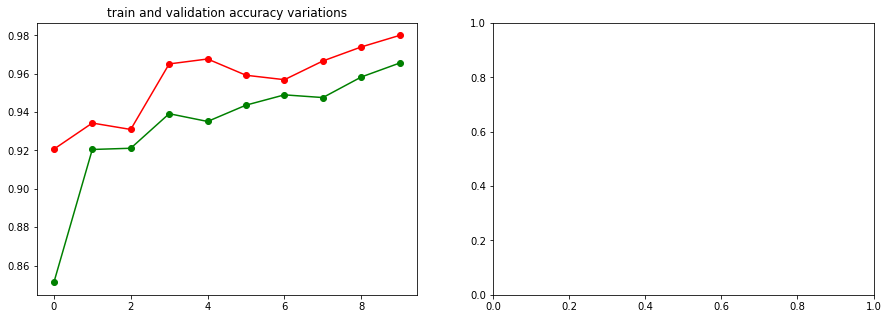

In [45]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_accuracy = history.history['val_accuracy']

# since we have trained on 10 epochs
epochs = [i for i in range(10)]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epochs, train_accuracy, 'go-', label = 'train accuracy')
ax[0].plot(epochs, valid_accuracy, 'ro-' ,label = 'validation accuracy')
ax[0].set_title('train and validation accuracy variations')
ax[0].legend(loc ='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')


ax[1].plot(epochs, train_loss, 'go-', label = 'train loss')
ax[1].plot(epochs, valid_loss, 'ro-', label = 'validation loss')
ax[1].set_title('train and validation loss variations')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

### Classification report

Lets look the classification report which will give us the precision, recall, f1_score, etc

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# prediction on the validation
prediction = model.predict_classes(tokenized_valid_padded_X)
prediction

### Confusion matrix

In [ ]:
cm = confusion_matrix(y_valid, prediction)
cm

In [ ]:
cm = pd.DataFrame(cm, columns = ['Fake', 'Not Fake'], index = ['Fake', 'Not Fake'])
cm

In [ ]:
plt.figure(figsize=(10, 5))
# annot_kws={"size": 15} to change the font size for the numbers
sns.heatmap(cm, annot=True, cmap='Blues', linecolor='black', linewidth=1, fmt='', cbar=False, annot_kws={"size": 15})
plt.xlabel('Actuals', fontsize= 15)
plt.ylabel('Predictions', fontsize=15)

In [ ]:
print(classification_report(y_valid, prediction, target_names = ['fake', 'not fake']))